In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%time
train = pd.read_csv("train.csv")

Wall time: 152 ms


In [3]:
train.shape

(891, 12)

In [4]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000011804D50908>,
      dtype=object)

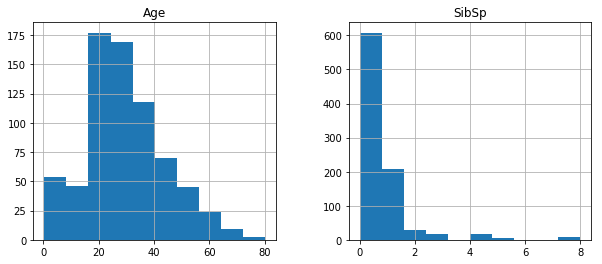

In [7]:
train[["Age", "SibSp"]].hist(figsize=(10, 4))

C:\Users\hfuis\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000011806E9FB70>,
      dtype=object)

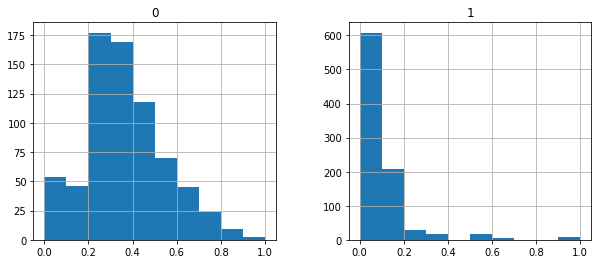

In [10]:
#MinMaxscaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
xtrain = scaler.fit_transform(train[["Age", "SibSp"]])
pd.DataFrame(xtrain).hist(figsize=(10, 4))

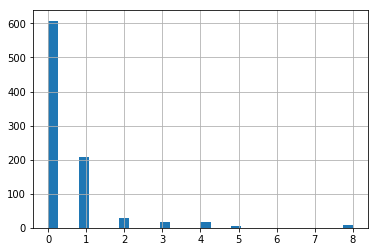

In [19]:
#winsorization(外れ値の対応)
x = pd.Series(train["SibSp"])
x.hist(bins = 30)

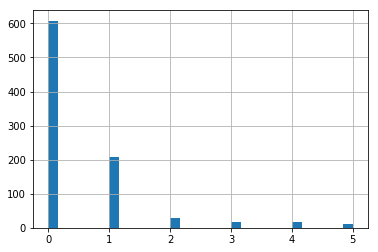

In [28]:
#99分位数まで限定。
LOWER, UPPER = np.percentile(x,[0,99])
#外れ値を最大、最小値に変更。
y = np.clip(x, LOWER, UPPER)
pd.Series(y).hist(bins = 30)

In [4]:
# Bag of words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [16]:
word = ["(excited) Hi everyone!", "I am so excited about this course!", "So excited. SO EXCITED. EXCITED, I AM!"]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(word)
features = vectorizer.get_feature_names()

print(features)

print(type(X))
print(X)
print(X.shape)
print(X.toarray())

['about', 'am', 'course', 'everyone', 'excited', 'hi', 'so', 'this']
<class 'scipy.sparse.csr.csr_matrix'>
  (0, 4)	1
  (0, 5)	1
  (0, 3)	1
  (1, 4)	1
  (1, 1)	1
  (1, 6)	1
  (1, 0)	1
  (1, 7)	1
  (1, 2)	1
  (2, 4)	3
  (2, 1)	1
  (2, 6)	2
(3, 8)
[[0 0 0 1 1 1 0 0]
 [1 1 1 0 1 0 1 1]
 [0 1 0 0 3 0 2 0]]


In [22]:
#term frequency
X_tf = X.toarray()
tf = 1/X_tf.sum(axis = 1)[:, None]
X_tf = X_tf*tf #行ごとの積(行列の積ではない)

print(X.toarray())
print(X_tf)
print(tf)
print(X_tf.shape)

[[0 0 0 1 1 1 0 0]
 [1 1 1 0 1 0 1 1]
 [0 1 0 0 3 0 2 0]]
[[0.         0.         0.         0.33333333 0.33333333 0.33333333
  0.         0.        ]
 [0.16666667 0.16666667 0.16666667 0.         0.16666667 0.
  0.16666667 0.16666667]
 [0.         0.16666667 0.         0.         0.5        0.
  0.33333333 0.        ]]
[[0.33333333]
 [0.16666667]
 [0.16666667]]
(3, 8)


In [23]:
#inverse document frequency
X_idf = X_tf
idf = np.log(X_idf.shape[0]/(X_idf > 0).sum(0))
X_idf = X_idf*idf

print(X.toarray())
print(X_tf)
print(X_idf)
print(idf)
print(X_idf.shape)

[[0 0 0 1 1 1 0 0]
 [1 1 1 0 1 0 1 1]
 [0 1 0 0 3 0 2 0]]
[[0.         0.         0.         0.33333333 0.33333333 0.33333333
  0.         0.        ]
 [0.16666667 0.16666667 0.16666667 0.         0.16666667 0.
  0.16666667 0.16666667]
 [0.         0.16666667 0.         0.         0.5        0.
  0.33333333 0.        ]]
[[0.         0.         0.         0.3662041  0.         0.3662041
  0.         0.        ]
 [0.18310205 0.06757752 0.18310205 0.         0.         0.
  0.06757752 0.18310205]
 [0.         0.06757752 0.         0.         0.         0.
  0.13515504 0.        ]]
[1.09861229 0.40546511 1.09861229 1.09861229 0.         1.09861229
 0.40546511 1.09861229]
(3, 8)


In [25]:
word = ["(excited) Hi everyone!", "I'm so excited about this course!", "So excited. SO EXCITED. EXCITED, I AM!"]

vectorizer = TfidfVectorizer(use_idf=True, token_pattern=u'(?u)\\b\\w+\\b')
X = vectorizer.fit_transform(word)
features = vectorizer.get_feature_names()

print(features)

print(type(X))
print(X)
print(X.shape)
print(X.toarray())

['about', 'am', 'course', 'everyone', 'excited', 'hi', 'i', 'm', 'so', 'this']
<class 'scipy.sparse.csr.csr_matrix'>
  (0, 3)	0.652490884512534
  (0, 5)	0.652490884512534
  (0, 4)	0.3853716274664007
  (1, 2)	0.42618350336974425
  (1, 9)	0.42618350336974425
  (1, 0)	0.42618350336974425
  (1, 8)	0.3241235393856436
  (1, 7)	0.42618350336974425
  (1, 6)	0.3241235393856436
  (1, 4)	0.2517108425440014
  (2, 1)	0.3771184202482633
  (2, 8)	0.5736165579940053
  (2, 6)	0.2868082789970027
  (2, 4)	0.6681966421670656
(3, 10)
[[0.         0.         0.         0.65249088 0.38537163 0.65249088
  0.         0.         0.         0.        ]
 [0.4261835  0.         0.4261835  0.         0.25171084 0.
  0.32412354 0.4261835  0.32412354 0.4261835 ]
 [0.         0.37711842 0.         0.         0.66819664 0.
  0.28680828 0.         0.57361656 0.        ]]


In [4]:
#Ngrams
from sklearn.feature_extraction.text import CountVectorizer

word = ["(excited) Hi everyone!", "I am so excited about this course!", "So excited. SO EXCITED. EXCITED, I AM!"]

vectorizer = CountVectorizer(ngram_range = (2, 2))
X = vectorizer.fit_transform(word)
features = vectorizer.get_feature_names()

print(features)

print(type(X))
print(X)
print(X.shape)
print(X.toarray())

['about this', 'am so', 'excited about', 'excited am', 'excited excited', 'excited hi', 'excited so', 'hi everyone', 'so excited', 'this course']
<class 'scipy.sparse.csr.csr_matrix'>
  (0, 5)	1
  (0, 7)	1
  (1, 1)	1
  (1, 8)	1
  (1, 2)	1
  (1, 0)	1
  (1, 9)	1
  (2, 8)	2
  (2, 6)	1
  (2, 4)	1
  (2, 3)	1
(3, 10)
[[0 0 0 0 0 1 0 1 0 0]
 [1 1 1 0 0 0 0 0 1 1]
 [0 0 0 1 1 0 1 0 2 0]]


In [5]:
#lowercase
word = ["Very, very sunny.","Sunny...sunny!"]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(word)
features = vectorizer.get_feature_names()

print(features)

print(type(X))
print(X)
print(X.shape)
print(X.toarray())

['sunny', 'very']
<class 'scipy.sparse.csr.csr_matrix'>
  (0, 1)	2
  (0, 0)	1
  (1, 0)	2
(2, 2)
[[1 2]
 [2 0]]
